In [1]:
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import copy
from random import shuffle
import math
import re

In [2]:
veh_N = 25
veh_cap = 200
veh_n = veh_N

In [3]:
data = pd.read_csv('C108.csv')

In [4]:
data[0:15]

,CUST,X,Y,DEMAND,START_T,END_T,SERVICE_T
0,0,40,50,0,0,1236,0
1,1,45,68,10,830,1049,90
2,2,45,70,30,756,939,90
3,3,42,66,10,16,336,90
4,4,42,68,10,643,866,90
5,5,42,65,10,15,226,90
6,6,40,69,20,499,824,90
7,7,40,66,20,87,308,90
8,8,38,68,20,150,429,90
9,9,38,70,10,429,710,90


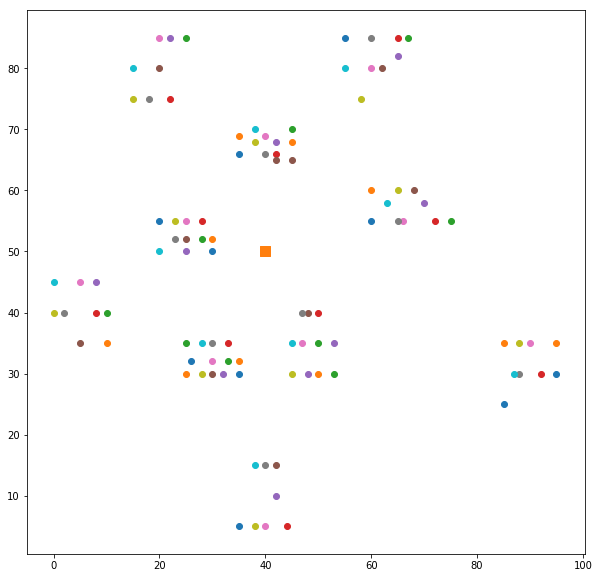

In [5]:
plt.figure(figsize=(10, 10))
for p in data.values:
    plt.scatter(p[1],p[2])
plt.scatter(data.values[0][1],data.values[0][2], marker='s',s=100 )
plt.show()

In [6]:
class Customer(object):
    def __init__(self, number, x, y, demand, start_t, end_t, service_t):
        self.number: int = number
        self.x: int = x
        self.y: int = y
        self.demand: int = demand
        self.start_t: int = start_t
        self.end_t: int = end_t
        self.service_t: int = service_t
        self.is_visited = False
    def __repr__(self):
        return f"Customer {self.number, self.x, self.y, self.demand, self.start_t, self.end_t, self.service_t, self.is_visited }"
    def distance(self, target):
        return ((self.x - target.x)**2 + (target.y - self.y)**2)**0.5
    def visited(self):
        self.is_visited = True
    def not_visited(self):
        self.is_visited = False

In [7]:
class Route(object):
    def __init__(self, depot, capacity, customs = []):
        customs.insert(0, depot)
        customs.append(depot)
        self._customers: list = customs
        self._time_of_visiting: list = [0,0]    
        self.capacity: int = capacity
        self.used = False
        self.total_distance: float = 0
    def __repr__(self):
        return f"Route {self._customers,self._time_of_visiting, self.capacity, self.used,self.total_distance }"
    
    
    def add_customer(self, customer):
        self.capacity -= customer.demand
        dist = self._customers[-2].distance(customer)
        cur_time = max(self._time_of_visiting[-2] + dist, customer.start_t) + customer.service_t 
        self.total_distance += dist+self._customers[-1].distance(customer) - self._customers[-1].distance(self._customers[-2])
        n_cust = len(self._customers)
        (self._time_of_visiting).insert(n_cust-1, cur_time)
        (self._customers).insert(n_cust-1, customer)
        (self._time_of_visiting)[n_cust] = cur_time + self._customers[-1].distance(customer)
        customer.visited()

        
    def check_customer(self, customer):
        if (self.capacity>=customer.demand):
            dist = self._customers[-2].distance(customer)
            if (self._time_of_visiting[-2] + dist <= customer.end_t):
                if ((self._time_of_visiting[-2] + dist + self._customers[-1].distance(customer) + customer.service_t) <= self._customers[-1].end_t):
                    return dist
        return False
                   
    def calculate_total_distance(self):
        dist = 0
        for i in range(len(self._customers)-1):
            dist+=(self._customers[i]).distance(self._customers[i+1])
        return dist


    def locate_customer(self, customer):
        n_cust = len(self._customers)
        best_route = copy.deepcopy(self)
        for i in range(1,n_cust):
            new_route = copy.deepcopy(self)
            cust = copy.deepcopy(new_route._customers)
            cust = cust[:i] + [customer] + cust[i:]
            new_route._customers = copy.deepcopy(cust)
            existance = is_existing(new_route) 
            if (existance):
                new_route._time_of_visiting = existance[0]
                new_route.total_distance = existance[1]
                best_route = copy.deepcopy(new_route)
                customer.visited()
        self = copy.deepcopy(best_route)
        if (customer.is_visited):
            return True
        else:
            return False

In [8]:
def is_existing(route):
    route.capacity = veh_cap
    n_cust = len(route._customers)
    total_distance = 0
    cur_time = 0
    time_of_visiting = []
    for j in range(0, n_cust):
        route.capacity -= route._customers[j].demand 
        if ((cur_time <= route._customers[j].end_t) and (route.capacity>=0)):
                        cur_time = max(cur_time, route._customers[j].start_t) + route._customers[j].service_t 
                        time_of_visiting.append(cur_time)
                        if (j != n_cust - 1):
                            cur_time += route._customers[j].distance(route._customers[j+1])
                            total_distance += route._customers[j].distance(route._customers[j+1])                              
        else:
            break
    if (len(time_of_visiting) == n_cust):
        return [time_of_visiting, total_distance]
    return False

In [9]:
customers = [Customer(c[0],c[1],c[2],c[3],c[4],c[5],c[6]) for c in data.values]
routes = []
def initial_solution(routes):
    routes.clear()
    for i in range(len(customers)):
        customers[i].not_visited()
    for i in range(veh_n - len(routes)):
        routes.append(Route(customers[0], veh_cap,[]))

    customers[0].visited()
    customers.sort(key = lambda x: x.start_t)
    for c in customers:
        if (c.is_visited):
            continue
        min_dist=1000000
        suitable_route = None
        for i in range(veh_n):
            dist = routes[i].check_customer(c)
            if ((dist!=False) and (dist<=min_dist)):
                min_dist=dist
                suitable_route = i
        if (suitable_route != None):
            routes[suitable_route].add_customer(c)
    unvisited_customers = ([c for c in customers if (c.is_visited == False)])
    for c in unvisited_customers:
        for r in routes:
            if (r.locate_customer(c) == True):
                break
    return routes

def plot_routes(routes):
    plt.figure(figsize=(10, 10))
    for c in customers:
        plt.scatter(c.x,c.y, c="black")
    for r in routes:
        plt.plot([customer.x for customer in r._customers],[customer.y for customer in r._customers])

    plt.scatter(data.values[0][1],data.values[0][2], marker='s',s=100 )
    plt.show()
    print(sum([r.total_distance for r in routes]))

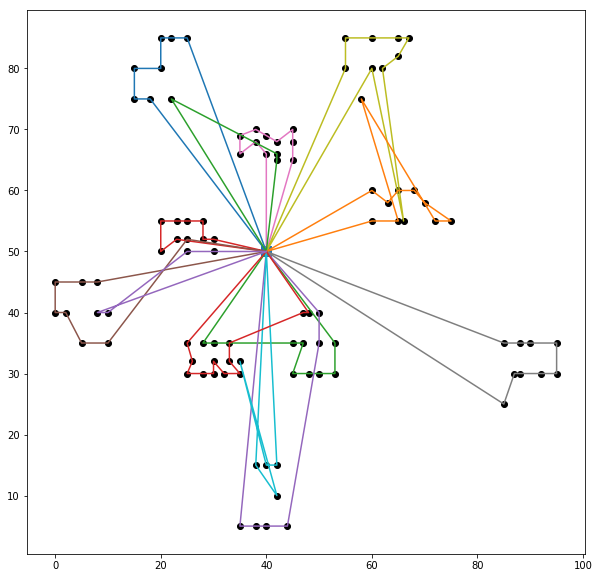

1194.7617191072661


In [25]:
routes = initial_solution(routes)
plot_routes(routes)

In [10]:
def swap(route0,route1):
    n =[len(route0._customers), len(route1._customers)]
    new_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    best_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    cust = [copy.deepcopy(route0._customers), copy.deepcopy(route1._customers)]
    for i in range(1, n[0]-1):
        for j in range(1, n[1]-1):
            a1 = cust[0][:i] + [cust[1][j]] + cust[0][i+1:]
            a2 = cust[1][:j] + [cust[0][i]] + cust[1][j+1:]
            new_route[0]._customers = a1
            new_route[1]._customers = a2 
            existance0 = is_existing(new_route[0])
            if (existance0):
                existance1 = is_existing(new_route[1])
                if (existance1):
                    if (existance0[1]+existance1[1] < best_route[0].total_distance + best_route[1].total_distance):
                        new_route[0]._time_of_visiting = existance0[0]
                        new_route[0].total_distance = existance0[1]
                        new_route[1]._time_of_visiting = existance1[0]
                        new_route[1].total_distance = existance1[1]
                        best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)    

def cross(route0,route1):
    n =[len(route0._customers), len(route1._customers)]
    new_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    best_route = [copy.deepcopy(route0),copy.deepcopy(route1)]
    cust = [copy.deepcopy(route0._customers), copy.deepcopy(route1._customers)]
    for i in range(1, n[0]-1):
        for j in range(1, n[1]-1):
            a1 = cust[0][:i+1] + cust[1][j+1:]
            a2 = cust[1][:j+1] + cust[0][i+1:]
            new_route[0]._customers = a1
            new_route[1]._customers = a2 
            existance0 = is_existing(new_route[0])
            if (existance0):
                existance1 = is_existing(new_route[1])
                if (existance1):
                    if (existance0[1]+existance1[1] < best_route[0].total_distance + best_route[1].total_distance):
                        new_route[0]._time_of_visiting = existance0[0]
                        new_route[0].total_distance = existance0[1]
                        new_route[1]._time_of_visiting = existance1[0]
                        new_route[1].total_distance = existance1[1]
                        best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)  

In [11]:
def two_opt(route):
    n_cust = len(route._customers)
    new_route = copy.deepcopy(route)
    best_route = copy.deepcopy(route)
    cust = copy.deepcopy(route._customers)
    if (n_cust<5):
        return best_route
    for i in range(n_cust-3):
        for j in range(i+2,n_cust-1):
            a = cust[:i+1]+ cust[i+1:j+1][::-1]+ cust[j+1::]     
            new_route._customers = copy.deepcopy(a)  
            existance = is_existing(new_route)
            if (existance):
                if (existance[1] < best_route.total_distance):
                    new_route._time_of_visiting = existance[0]
                    new_route.total_distance = existance[1]
                    best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)

def move_locate(route):
    n_cust = len(route._customers)
    best_route = copy.deepcopy(route)
    new_route = copy.deepcopy(route)
    cust = copy.deepcopy(route._customers)
    if (n_cust>2):
        for i in range(1,n_cust-2):
            for j in range(i+1,n_cust-1):
                new_route = copy.deepcopy(best_route)
                new_route._customers[i] = copy.deepcopy(best_route._customers[j])
                new_route._customers[j] = copy.deepcopy(best_route._customers[i])
                existance = is_existing(new_route)

                if (existance):
                    if (existance[1] < best_route.total_distance):
                        new_route._time_of_visiting = existance[0]
                        new_route.total_distance = existance[1]
                        best_route = copy.deepcopy(new_route)
    return copy.deepcopy(best_route)

In [12]:
def local_search(routes):
    plot_routes(routes)
    old_sum  = 1000000
    step = 0
    current_sum = sum([r.total_distance for r in routes])
    while old_sum - current_sum > 0.1: 
        old_sum = copy.deepcopy(current_sum)
        for i in range(len(routes)-1):
            for j in range(i+1, len(routes)):
                br = swap(routes[i], routes[j])
                routes[i] = copy.deepcopy(br[0])
                routes[j] = copy.deepcopy(br[1])
                br = cross(routes[i], routes[j])
                routes[i] = copy.deepcopy(br[0])
                routes[j] = copy.deepcopy(br[1])
        for i in range(len(routes)):
            routes[i] = two_opt(routes[i])
            routes[i] = move_locate(routes[i])
        current_sum = sum([r.total_distance for r in routes])
        step +=1
        print("STEP:{} \nCS:{}".format(step, current_sum))
    return routes

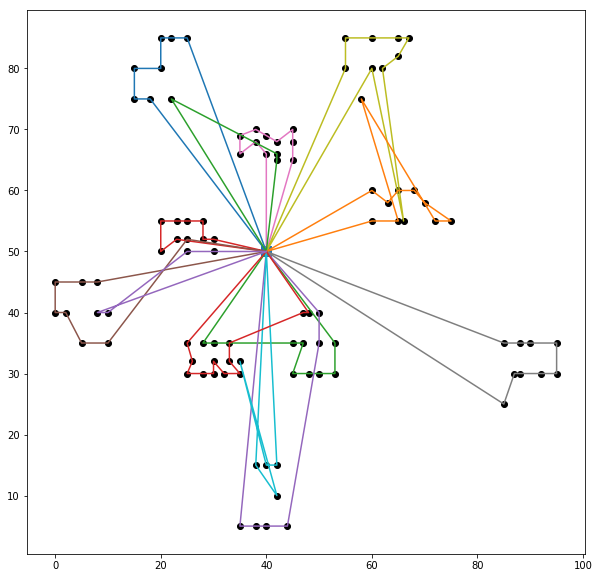

1194.7617191072661
CHANGING
CHANGING
CHANGING
CHANGING
CHANGING
STEP:1 
CS:1062.666986204984
STEP:2 
CS:1056.870204163131
STEP:3 
CS:1055.819910540861
STEP:4 
CS:1054.0520816052285
STEP:5 
CS:1054.0520816052285


In [156]:
routes = initial_solution(routes)
routes = local_search(routes)

In [13]:
def perturbation(routes):
    for i in range(len(routes)):
        print("IM ON ", str(i), " ROUTE")
        r = copy.deepcopy(routes[i])
        if (len(r._customers)>2):
            rr = copy.deepcopy(r)
            if (len(r._customers)<12):
                diap1, diap2 = 1, -1
            else:
                diap1 = len(r._customers) // 3
                diap2 = -diap1
            a = copy.deepcopy(r._customers[diap1:diap2])
            shuffle(a)
            r._customers[diap1:diap2] = copy.deepcopy(a)
            COUNT = math.factorial(abs(len(r._customers) - diap1 + diap2)) // 2 + 5
            k = 0
            
            while ((is_existing(r) == False) and (k < COUNT)):
                k += 1
                a = copy.deepcopy(r._customers[diap1:diap2])
                shuffle(a)
                r._customers[diap1:diap2] = copy.deepcopy(a)
                
            if (k>=COUNT):
                r = copy.deepcopy(rr)
            existance = is_existing(r)
            r._time_of_visiting = existance[0]
            r.total_distance = existance[1]
        routes[i] = copy.deepcopy(r)
    return(routes)

In [19]:
def ILS(routes):
#     routes = initial_solution(routes)
#     plot_routes(routes)
#     routes = local_search(routes)
#     plot_routes(routes)
    best_total_distance = sum([r.total_distance for r in routes])
    best_routes = copy.deepcopy(routes)

    for step in range(10):
        for i in range(len(routes)):
            if (is_existing(routes[i])==False):
                print("НЕТ ПУТИ ", str(i))
        routes = perturbation(routes)
        plot_routes(routes)
        routes = local_search(routes)
        current_distance = sum([r.total_distance for r in routes])

        plot_routes(routes)
        print("ILS. Step: {}, Sum: {}".format(step, current_distance))
        if (current_distance < best_total_distance):
            best_routes = copy.deepcopy(routes)
            best_total_distance = copy.deepcopy(current_distance)
    routes = copy.deepcopy(best_routes)
    print("OVERALL")
    plot_routes(routes)
    return best_routes

IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


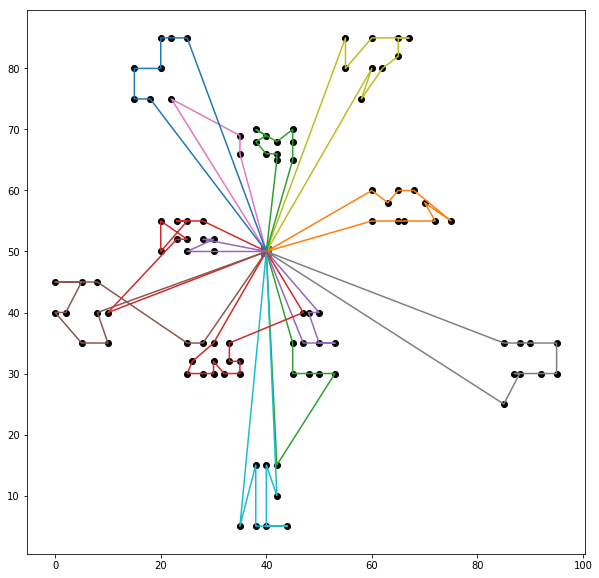

1108.761278457292


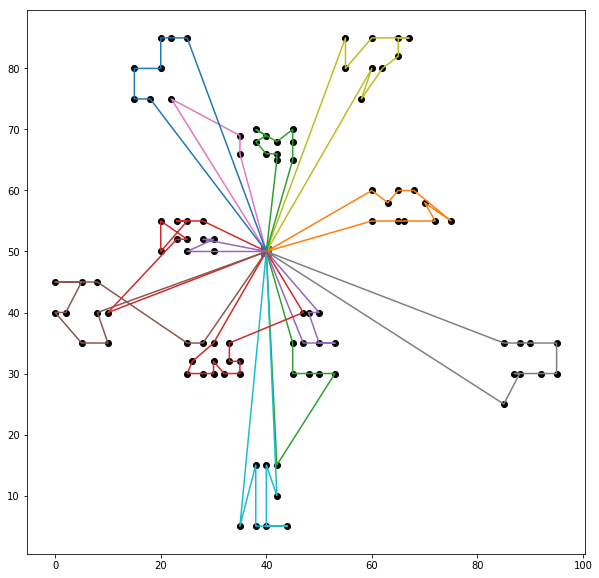

1108.761278457292
STEP:1 
CS:1030.3810862386483
STEP:2 
CS:1021.1712579046675
STEP:3 
CS:1021.1712579046675


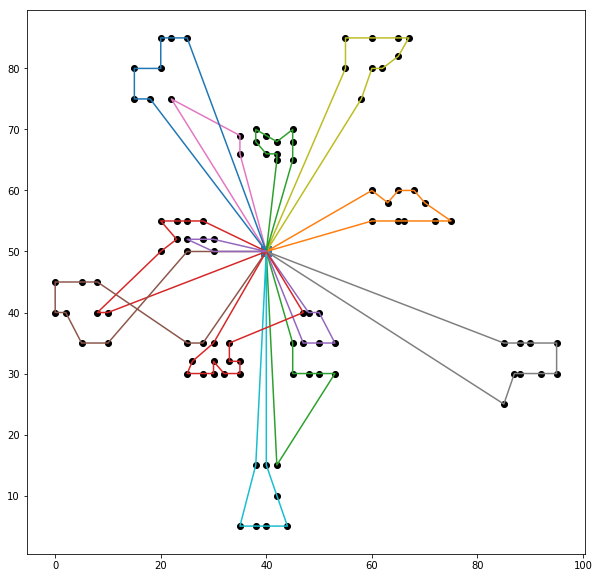

1021.1712579046675
ILS. Step: 0, Sum: 1021.1712579046675
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


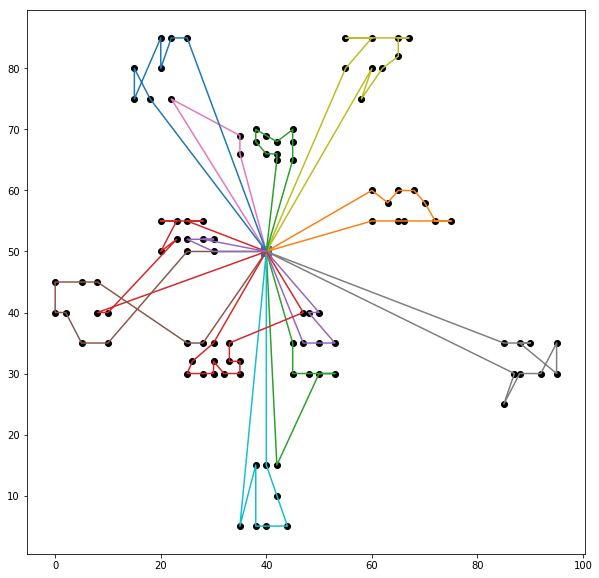

1104.8616553728612


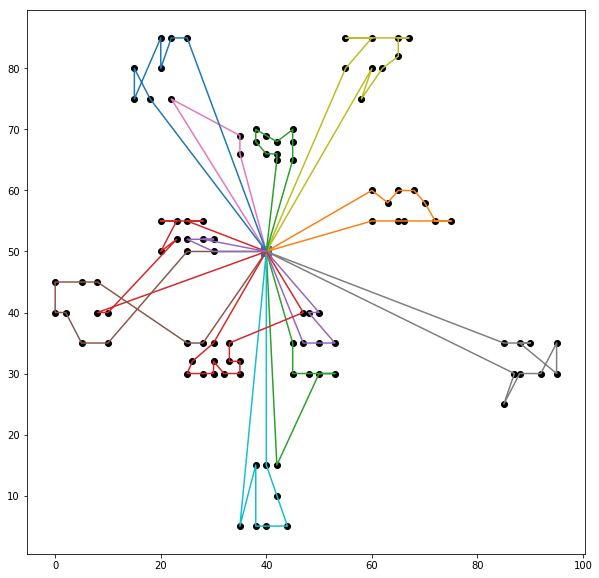

1104.8616553728612
STEP:1 
CS:1024.4276156149665
STEP:2 
CS:1021.1712579046675
STEP:3 
CS:1021.1712579046675


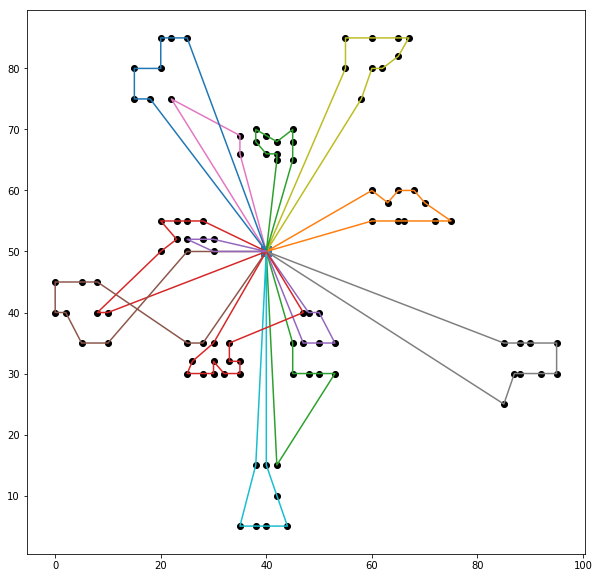

1021.1712579046675
ILS. Step: 1, Sum: 1021.1712579046675
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


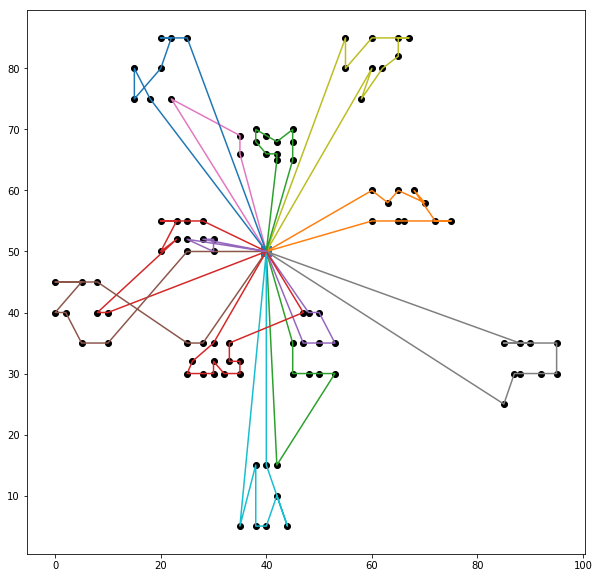

1107.2655776851768


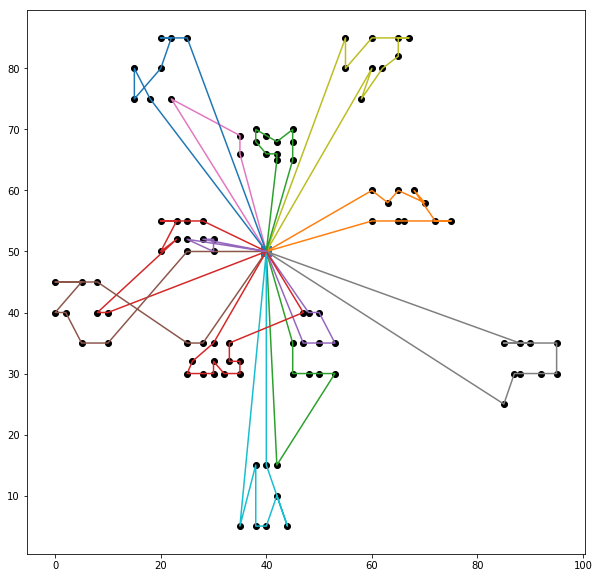

1107.2655776851768
STEP:1 
CS:1023.738414722533
STEP:2 
CS:1021.1712579046675
STEP:3 
CS:1021.1712579046675


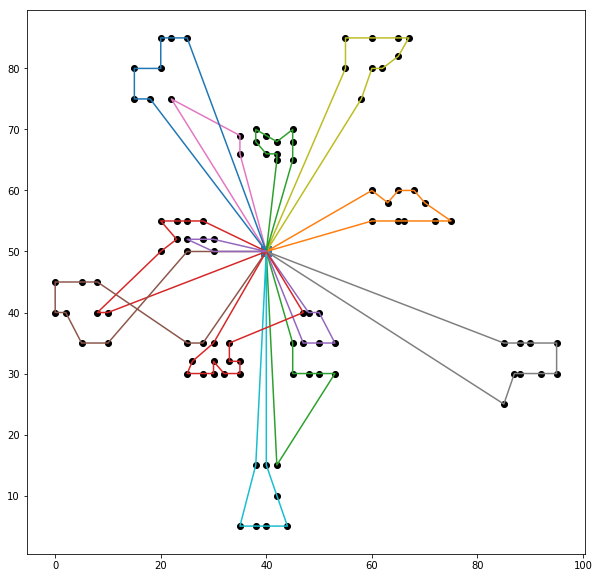

1021.1712579046675
ILS. Step: 2, Sum: 1021.1712579046675
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


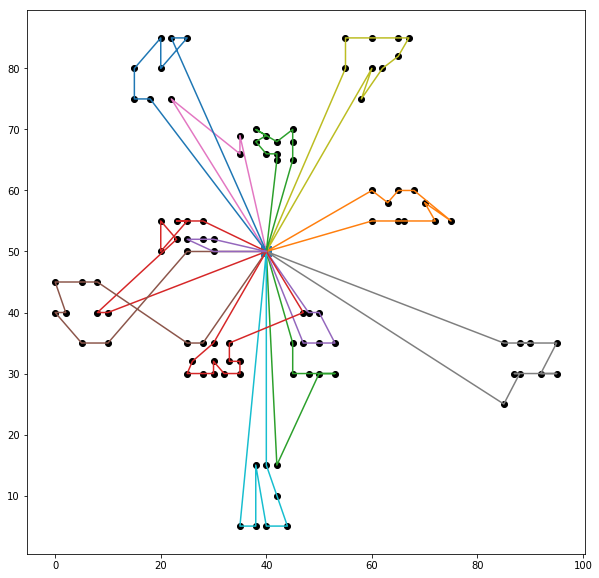

1093.8065356873406


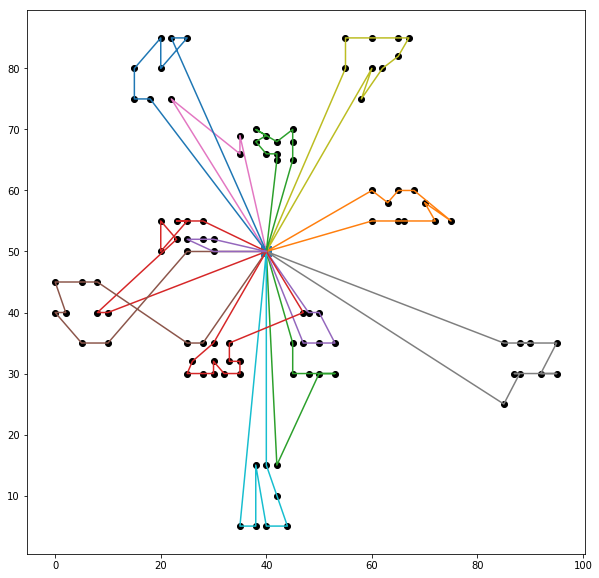

1093.8065356873406
STEP:1 
CS:1025.5174905780334
STEP:2 
CS:1021.1712579046675
STEP:3 
CS:1021.1712579046675


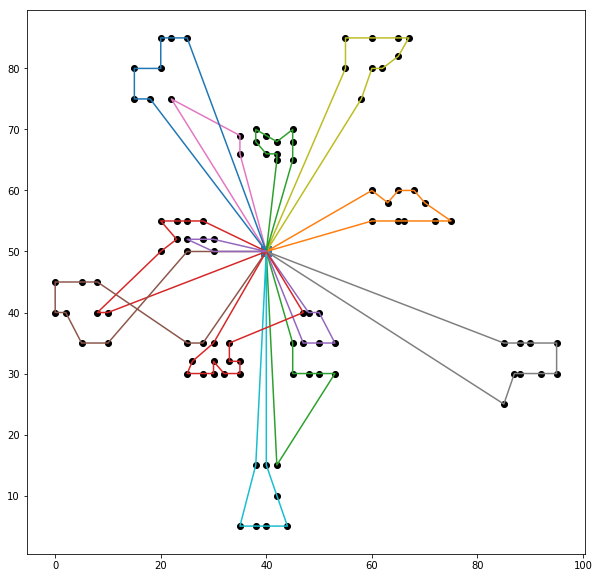

1021.1712579046675
ILS. Step: 3, Sum: 1021.1712579046675
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


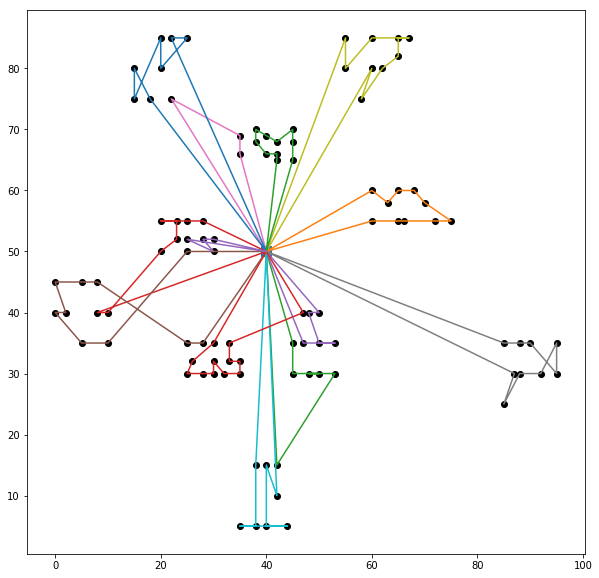

1096.4048166698026


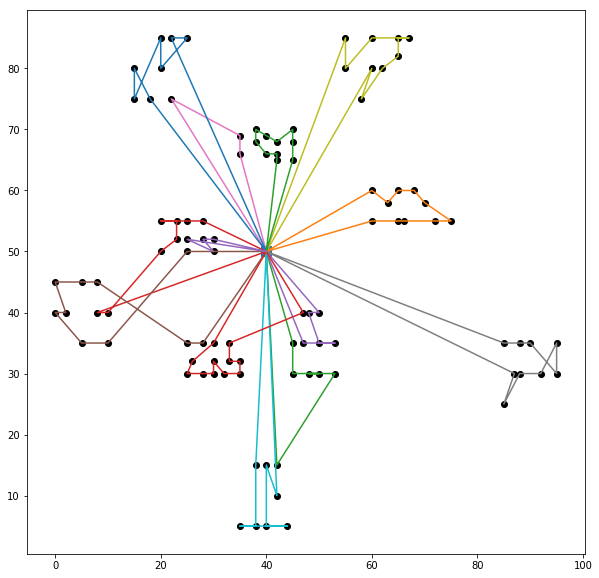

1096.4048166698026
STEP:1 
CS:1023.304003855089
STEP:2 
CS:1023.304003855089


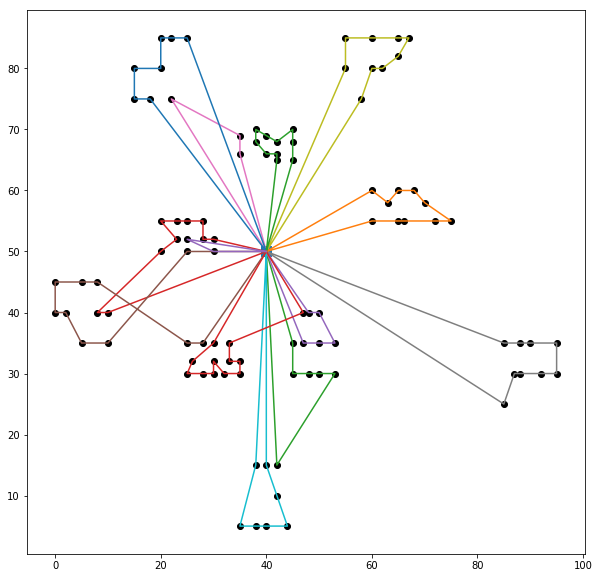

1023.304003855089
ILS. Step: 4, Sum: 1023.304003855089
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


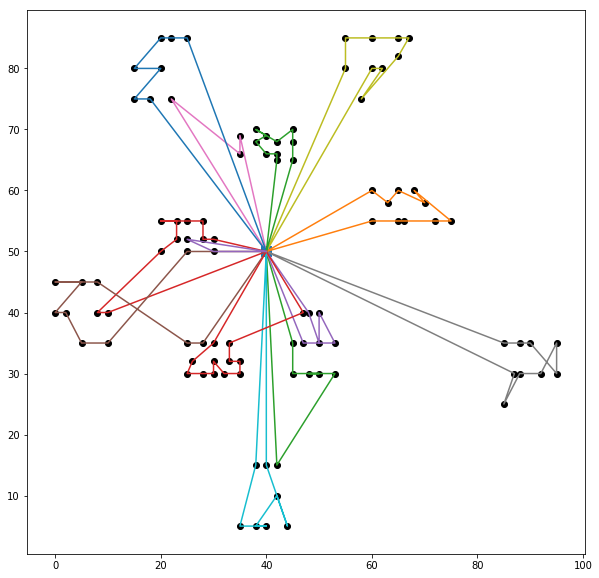

1092.34885421501


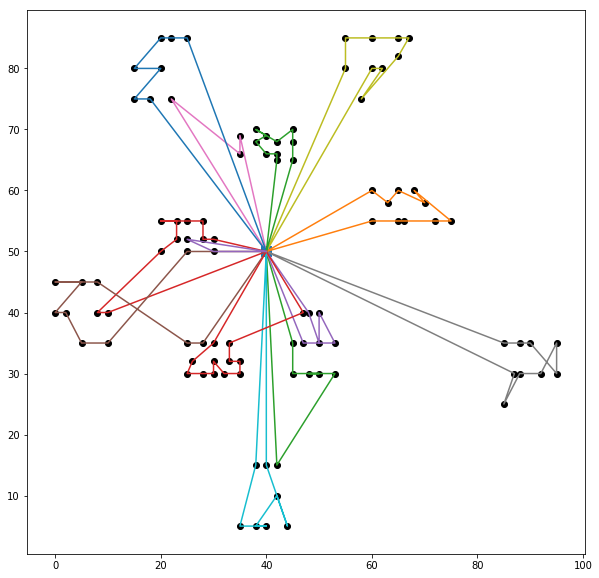

1092.34885421501
STEP:1 
CS:1023.304003855089
STEP:2 
CS:1023.304003855089


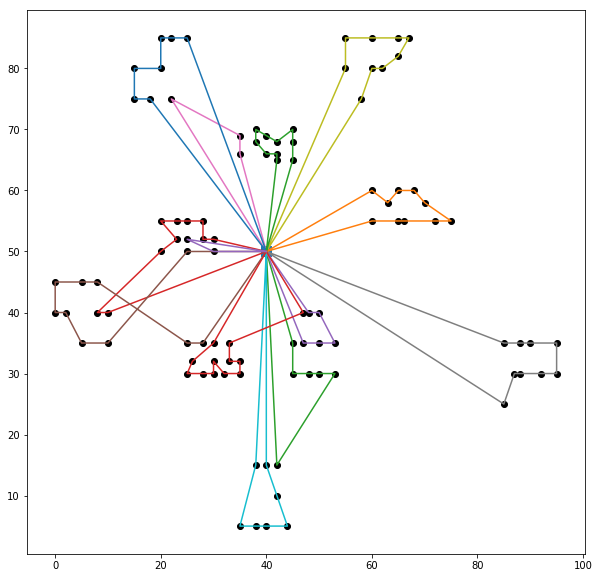

1023.304003855089
ILS. Step: 5, Sum: 1023.304003855089
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


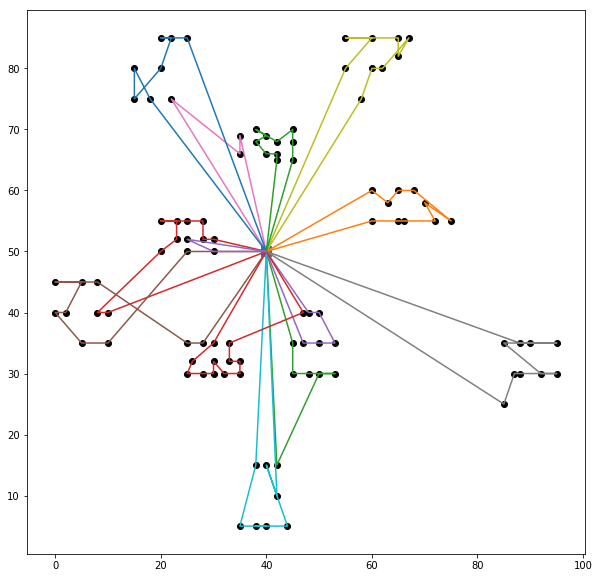

1096.4765631080566


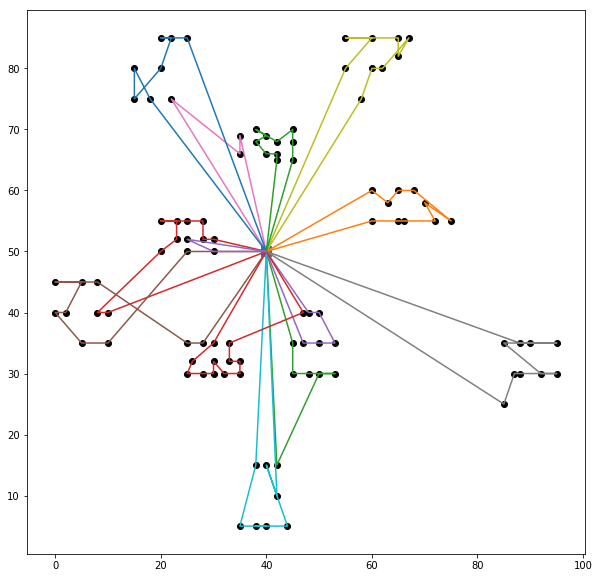

1096.4765631080566
STEP:1 
CS:1023.304003855089
STEP:2 
CS:1023.304003855089


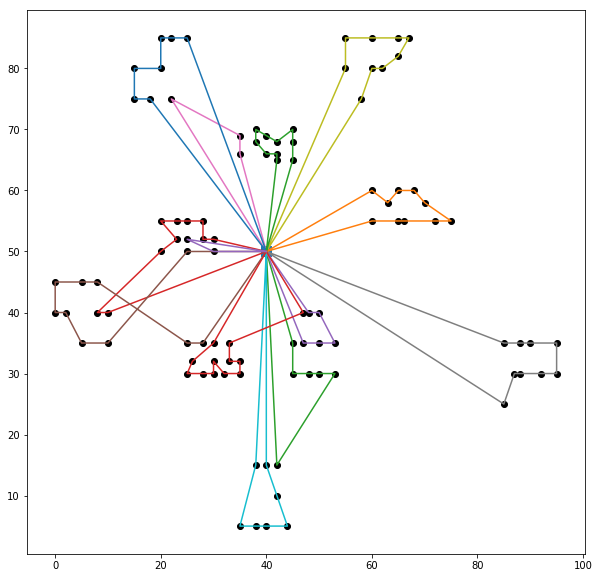

1023.304003855089
ILS. Step: 6, Sum: 1023.304003855089
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


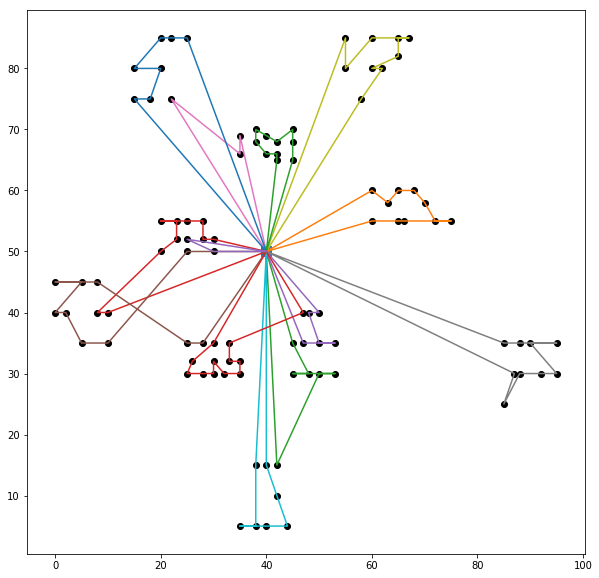

1075.77719148861


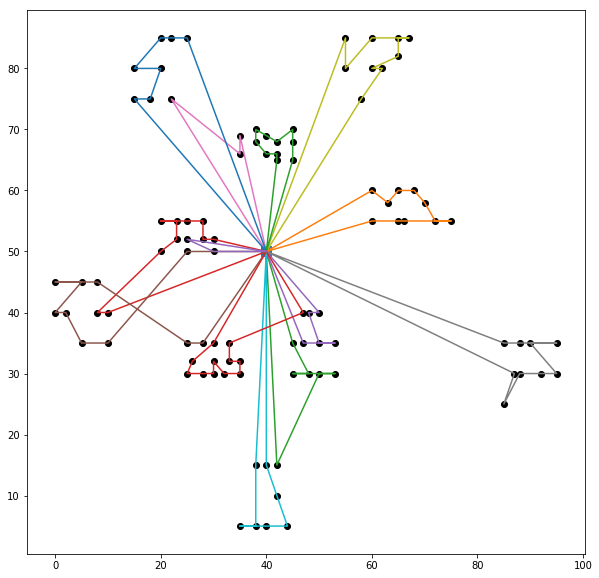

1075.77719148861
STEP:1 
CS:1027.3075644148576
STEP:2 
CS:1026.1221264129913
STEP:3 
CS:1025.0718327907214
STEP:4 
CS:1023.304003855089
STEP:5 
CS:1023.304003855089


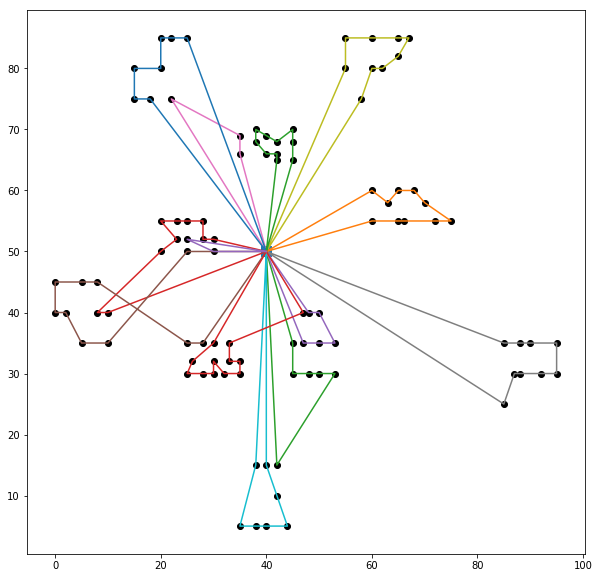

1023.304003855089
ILS. Step: 7, Sum: 1023.304003855089
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


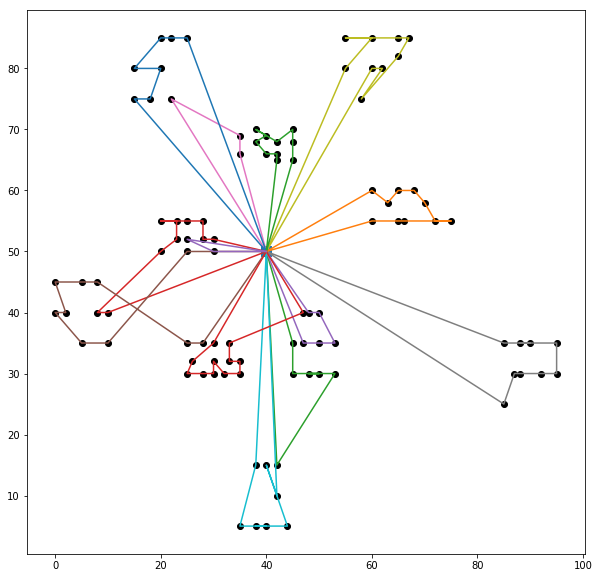

1076.5110729479654


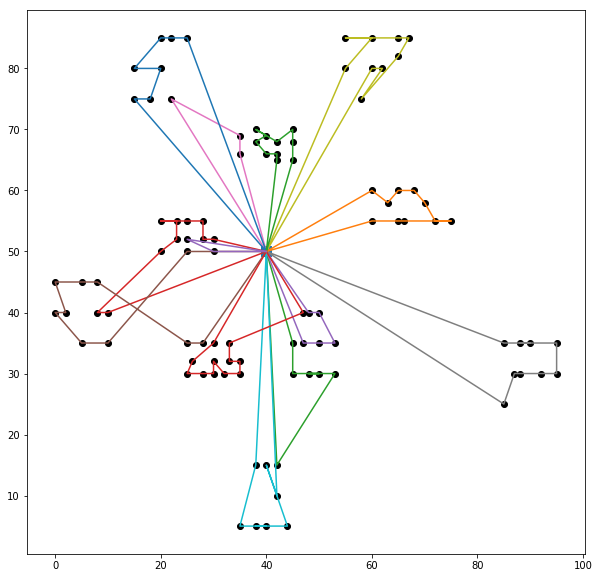

1076.5110729479654
STEP:1 
CS:1021.1712579046675
STEP:2 
CS:1021.1712579046675


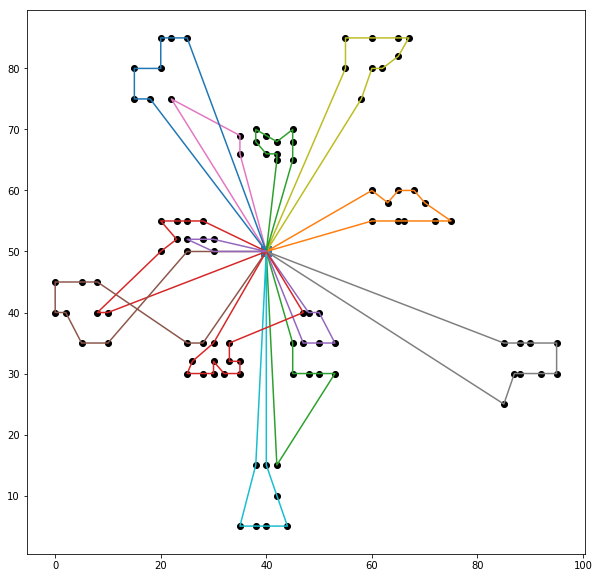

1021.1712579046675
ILS. Step: 8, Sum: 1021.1712579046675
IM ON  0  ROUTE
IM ON  1  ROUTE
IM ON  2  ROUTE
IM ON  3  ROUTE
IM ON  4  ROUTE
IM ON  5  ROUTE
IM ON  6  ROUTE
IM ON  7  ROUTE
IM ON  8  ROUTE
IM ON  9  ROUTE
IM ON  10  ROUTE
IM ON  11  ROUTE
IM ON  12  ROUTE
IM ON  13  ROUTE
IM ON  14  ROUTE
IM ON  15  ROUTE
IM ON  16  ROUTE
IM ON  17  ROUTE
IM ON  18  ROUTE
IM ON  19  ROUTE
IM ON  20  ROUTE
IM ON  21  ROUTE
IM ON  22  ROUTE
IM ON  23  ROUTE
IM ON  24  ROUTE


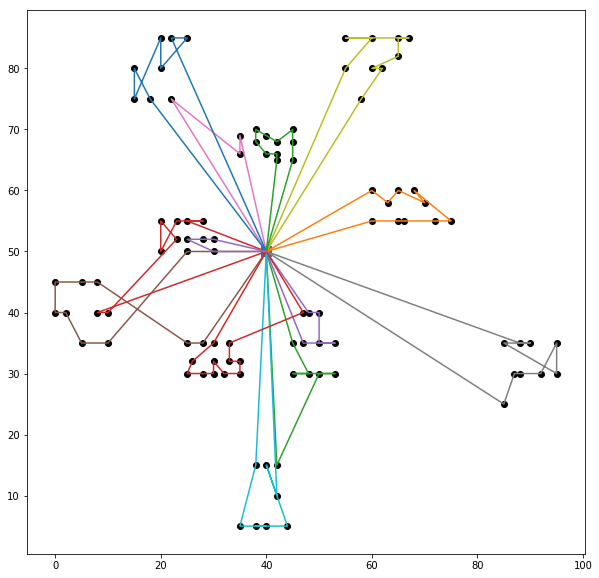

1107.04088957238


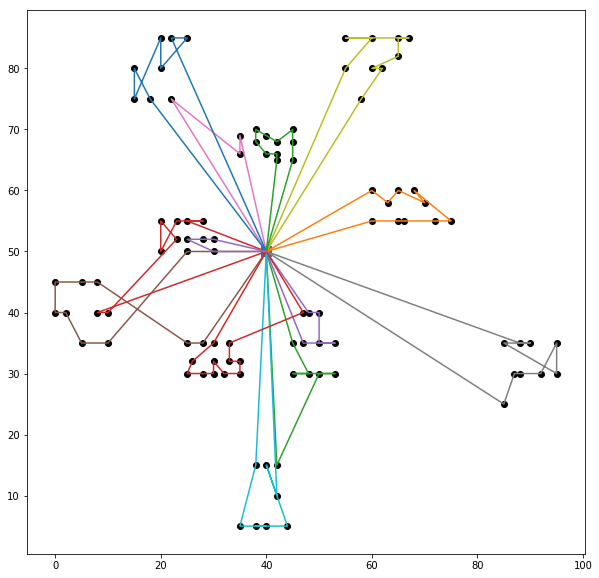

1107.04088957238
STEP:1 
CS:1029.5210511378018
STEP:2 
CS:1023.9893804625698
STEP:3 
CS:1022.9390868403
STEP:4 
CS:1021.1712579046675
STEP:5 
CS:1021.1712579046675


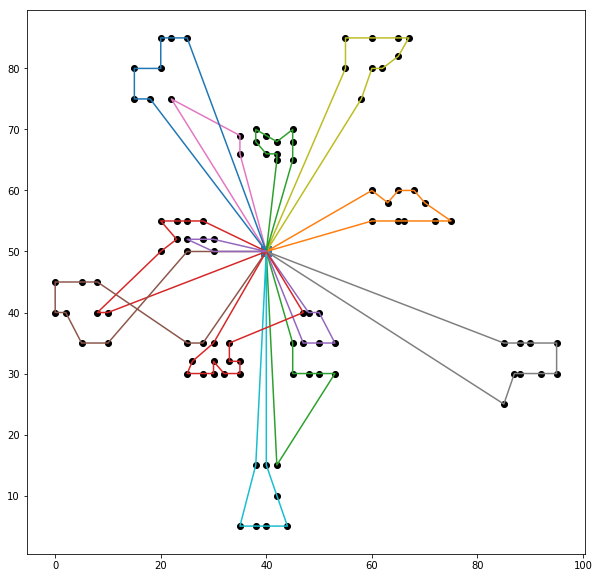

1021.1712579046675
ILS. Step: 9, Sum: 1021.1712579046675
OVERALL


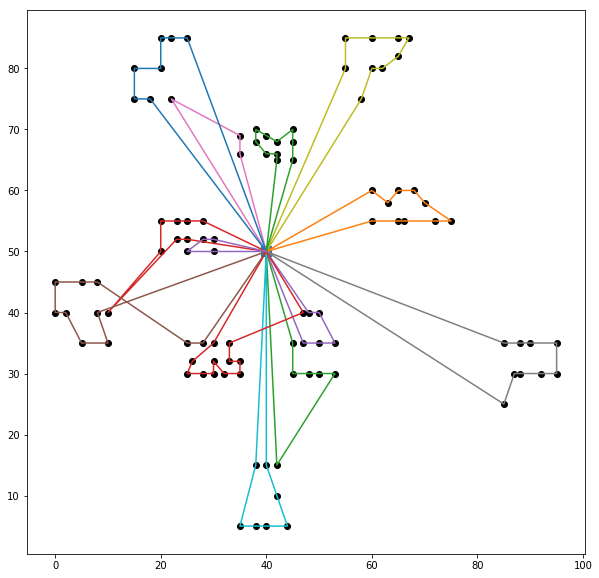

1020.9649346440417


In [20]:
routes = ILS(routes)

In [17]:
def nice_view(routes,name):
    file = open(name, 'w+')
    for r in routes:
        cur_time = 0
        if (len(r._customers)>2):
            res = str(0) + ' ' + str(0)
            for j in range(1, len(r._customers)):
                dist = r._customers[j-1].distance(r._customers[j]) 
                cur_time += dist + r._customers[j-1].service_t
                vt = max(cur_time, r._customers[j].start_t)
                cur_time = vt
                res = res +' ' + (str(r._customers[j].number) + ' ' + str(vt)  )
            file.write(res + "\n")
            print(res)
    file.close()
    total_file = open('VRP_total.txt', 'a+')
    total_file.write(name[:-4] + ' ' + str(sum([r.total_distance for r in routes]))+ "\n")
    print(name[:-4] + ' ' + str(sum([r.total_distance for r in routes]))+ "\n")
    total_file.close()
        

In [21]:
nice_view(routes, 'C108.txt')

0 0 55 35.05709628591621 72 367 61 460.0 64 552.0 68 669 69 836 0 941.8113883008419
0 0 25 88 27 180.0 32 287.69180601295415 29 391.8339416366851 30 486.8339416366851 28 579.833941636685 26 671.833941636685 23 764.833941636685 0 867.833941636685
0 0 65 12.806248474865697 63 104.8062484748657 74 263 62 356.0 66 753 0 859.5529453572468
0 0 33 33.52610922848042 31 144 35 239.0 37 334.83095189484527 38 426.83095189484527 39 521.8309518948453 36 616.8309518948453 34 709.8309518948453 52 825 49 918.0 0 1027.2093727122985
0 0 13 30.805843601498726 11 363 10 456.0 0 562.7630546142402
0 0 81 47.43416490252569 78 140.43416490252568 76 232.43416490252568 71 327.4341649025257 70 422.4341649025257 73 515.4341649025257 77 609.4341649025257 79 700.4341649025257 80 795.8193297096602 0 937.2974804145952
0 0 98 30.805843601498726 96 126.19100840863322 95 218.19100840863322 94 311.79655968409725 92 405.40211095956124 93 497.40211095956124 97 592.4021109595612 100 687.4021109595612 99 782.4021109595612 0 